# Human PBMCs from 10X data 

Here we analyse the 10k PBMCs from a healthy donor (v3 chemistry) (Cell Ranger 3.0.0).
Link to the dataset: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3

In [9]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#import preprocessing as scIBpp

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [10]:
# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+6.ge614f59 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [11]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/pbmc10x.h5ad'  # the file that will store the analysis results

In [12]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

R[write to console]: Loading required package: BiocParallel

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans

In [13]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)

In [14]:
# Set up data loading
file_base = '../../Munich/datasets/human/10xPBMC/filtered_feature_bc_matrix/'
adata = sc.read_10x_mtx(path=file_base, var_names='gene_symbols', make_unique=True, cache=True, gex_only=True )

... reading from cache file cache/..-..-Munich-datasets-human-10xPBMC-filtered_feature_bc_matrix-matrix.h5ad


In [15]:
adata

View of AnnData object with n_obs × n_vars = 11769 × 33538 
    var: 'gene_ids', 'feature_types'

In [16]:
adata.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


In [17]:
adata.X = adata.X.toarray()

In [18]:
adata.var_names_make_unique()

In [19]:
# Checking the total size of the data set
adata.shape

(11769, 33538)

# Pre-processing and visualization

## Quality control

In [20]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [21]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


... storing 'feature_types' as categorical


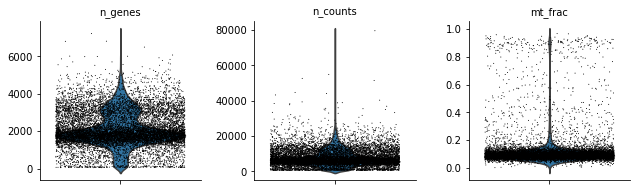

In [22]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

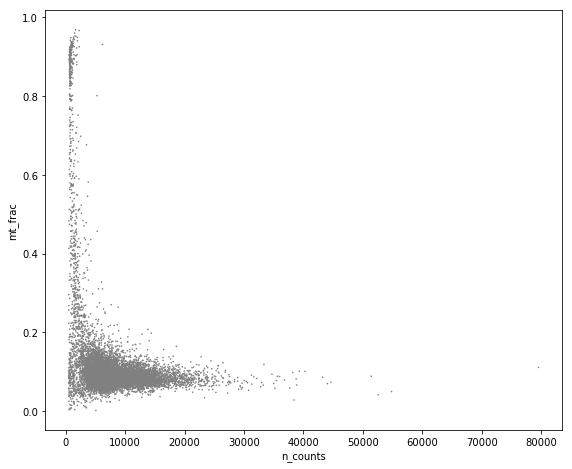

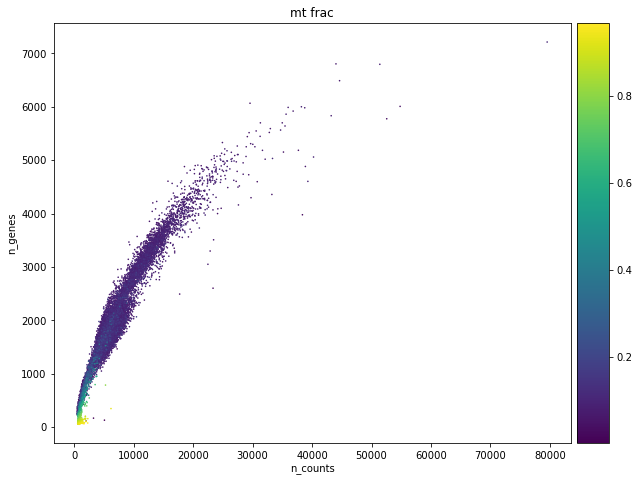

In [23]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

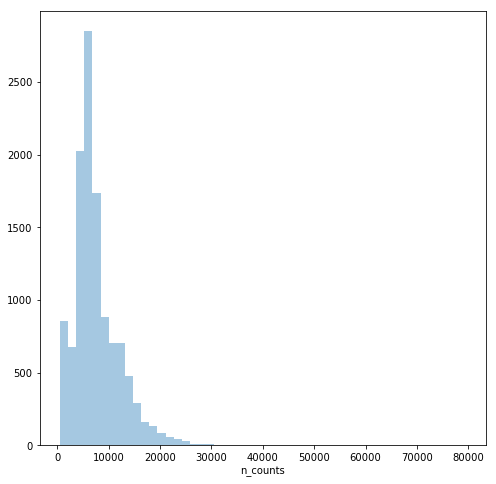

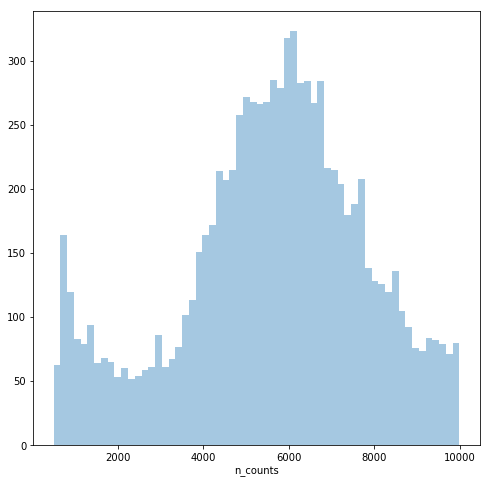

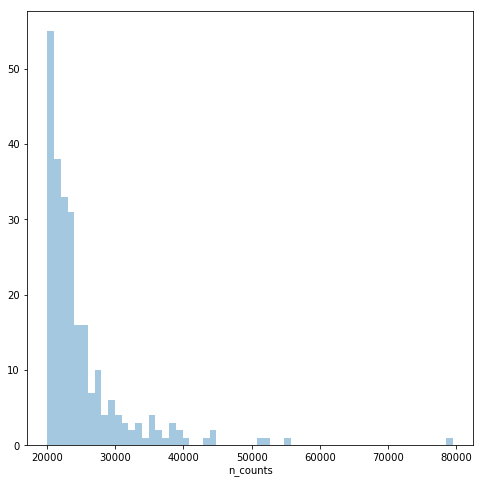

In [24]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<10000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>20000], kde=False, bins=60)
plt.show()

Zoom-in histograms of the number of counts per cell show that there's a smaller group of cells with n_counts < 2000 which are likely uninformative. On the upper end of the distribution, we can see that the high peak centered around 20000 counts spans until around 40000 counts.

In [26]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))


Total number of cells: 11769
filtered out 825 cells that haveless than 2000 counts
Number of cells after min count filter: 10944
filtered out 8 cells that havemore than 40000 counts
Number of cells after max count filter: 10936
Number of cells after MT filter: 10743


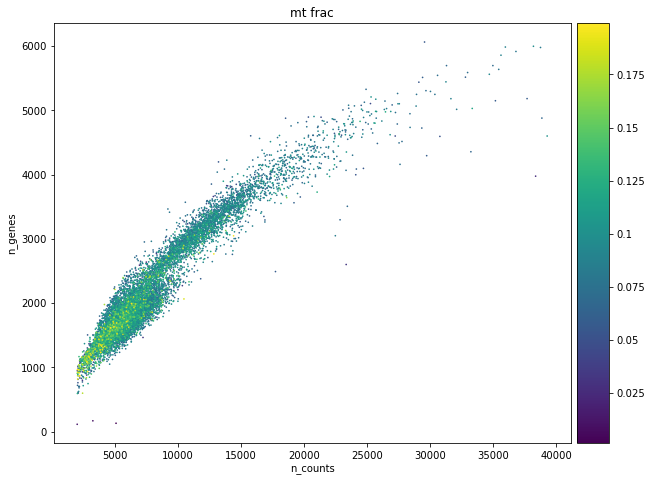

In [27]:
# look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

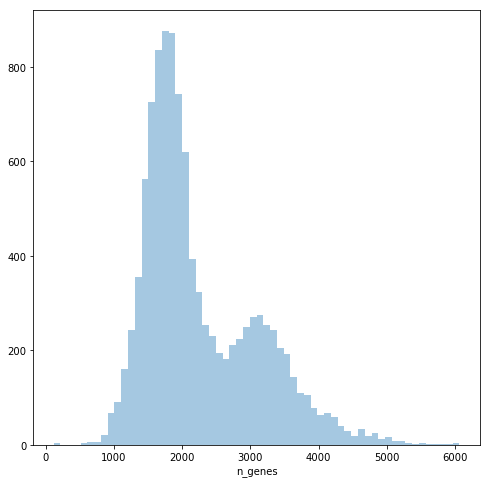

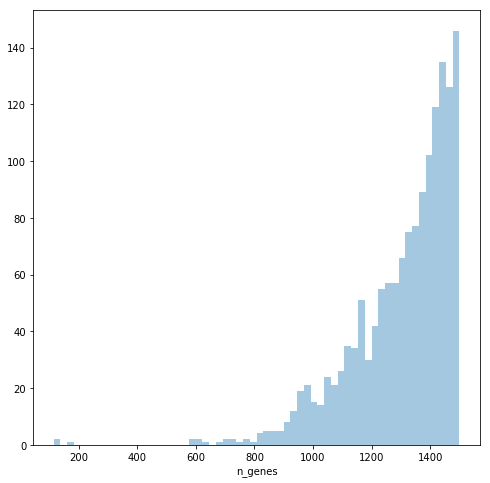

In [28]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1500], kde=False, bins=60)
plt.show()



From the histograms of the number of genes per cell, we can notice that there still is a small population showing n_genes < 800 which should be filtered out.

In [29]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 800)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 10743
filtered out 16 cells that haveless than 800 genes expressed
Number of cells after gene filter: 10727


In [30]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33538
filtered out 17704 genes that are detectedin less than 20 cells
Number of genes after cell filter: 15834


## Normalization

In [31]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02)


In [32]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [33]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [34]:
#Delete adata_pp
del adata_pp

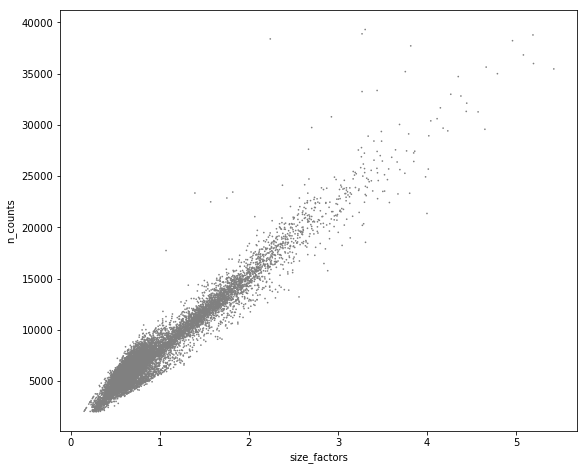

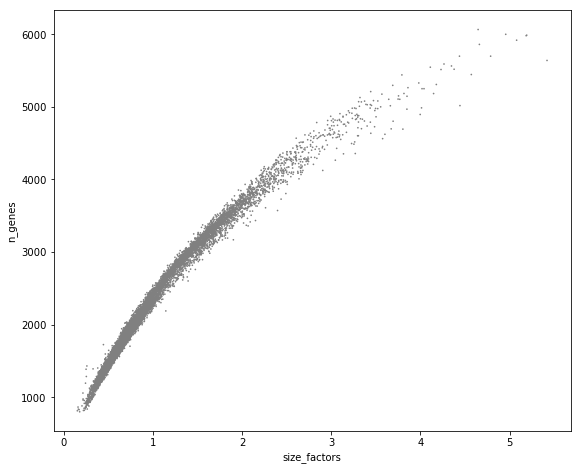

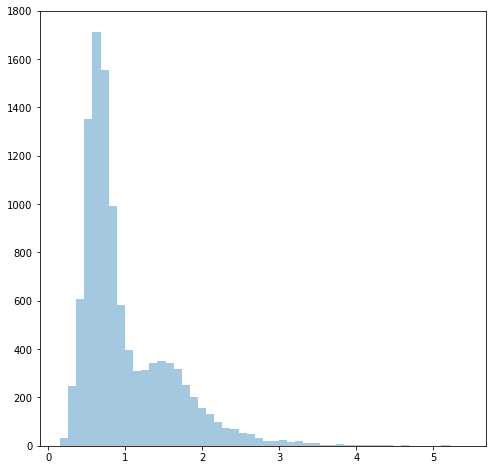

In [35]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [36]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [37]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [38]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## Highly variable genes

In [39]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


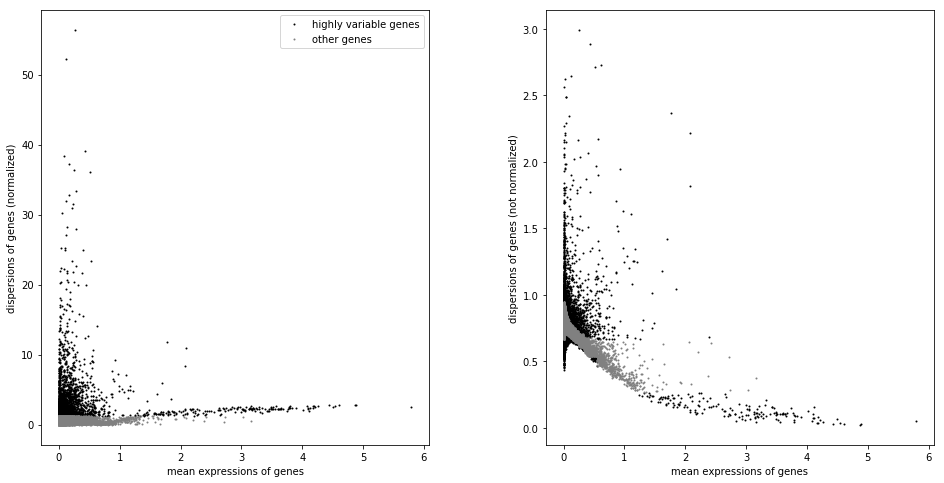

In [40]:
sc.pl.highly_variable_genes(adata)

## Visualization

In [42]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:04)
computing UMAP


/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:15)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9998986  0.9994045  0.9982399  0.99672824
     0.99216354 0.98910457 0.98872167 0.9861633  0.98209685 0.9819014
     0.9780419  0.9762579  0.9731303 ]
    finished (0:00:01)
drawing single-cell graph using layout 'fa'
    finished (0:02:29)


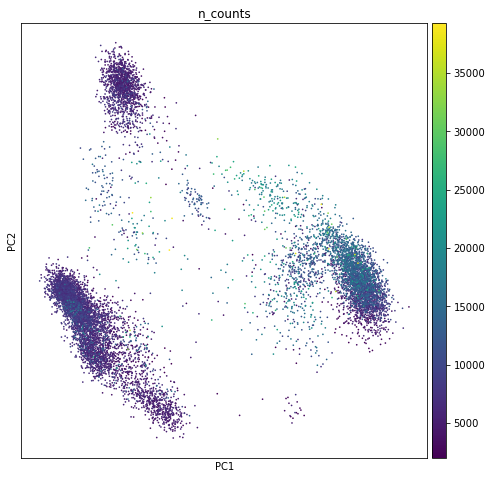

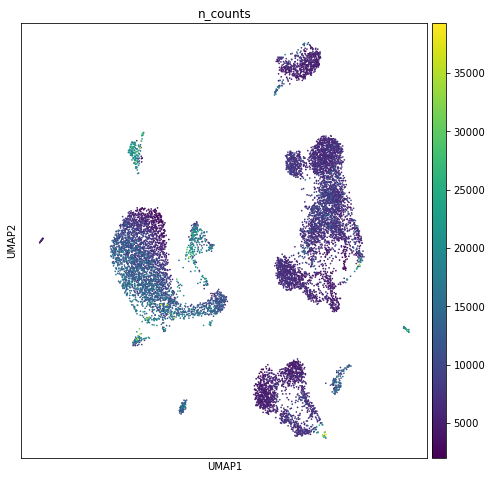

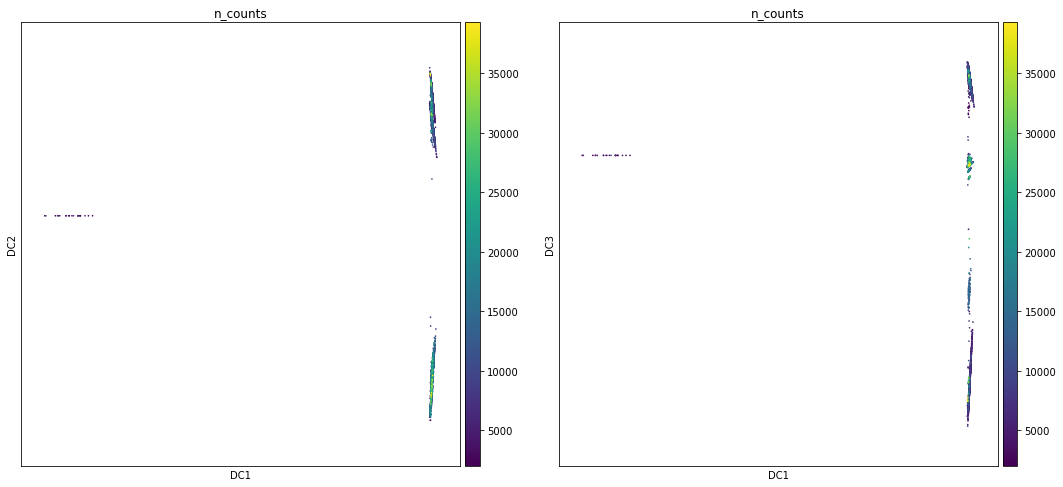

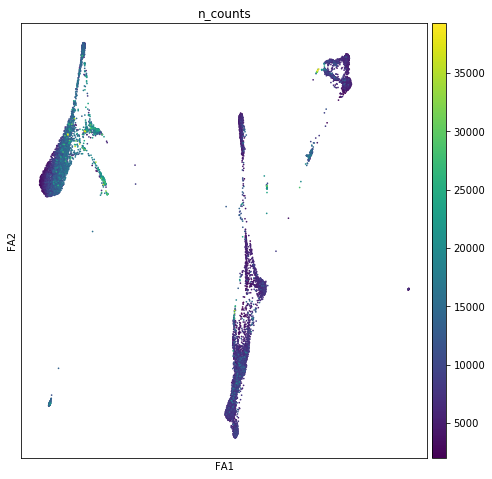

In [43]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [44]:
adata.write(results_file)

## Clustering

In [45]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)


In [46]:
adata.obs['louvain_r0.5'].value_counts()

0     3071
1     2049
2     1446
3     1435
4     1013
5      602
6      369
7      311
8      183
9      118
10      81
11      28
12      21
Name: louvain_r0.5, dtype: int64

In [47]:
adata.obs['louvain_r1'].value_counts()

0     1910
1     1610
2     1121
3     1119
4      796
5      603
6      600
7      559
8      394
9      380
10     343
11     284
12     242
13     237
14     207
15     118
16      81
17      74
18      28
19      21
Name: louvain_r1, dtype: int64

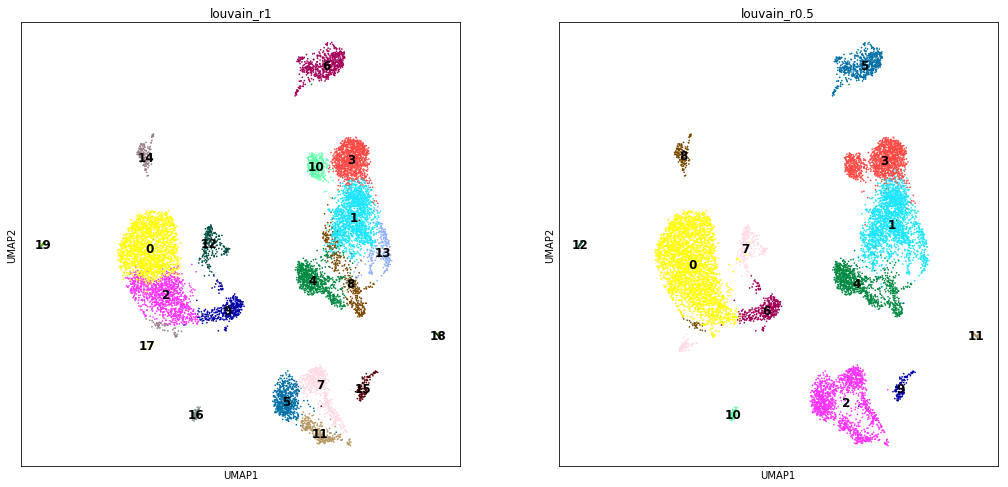

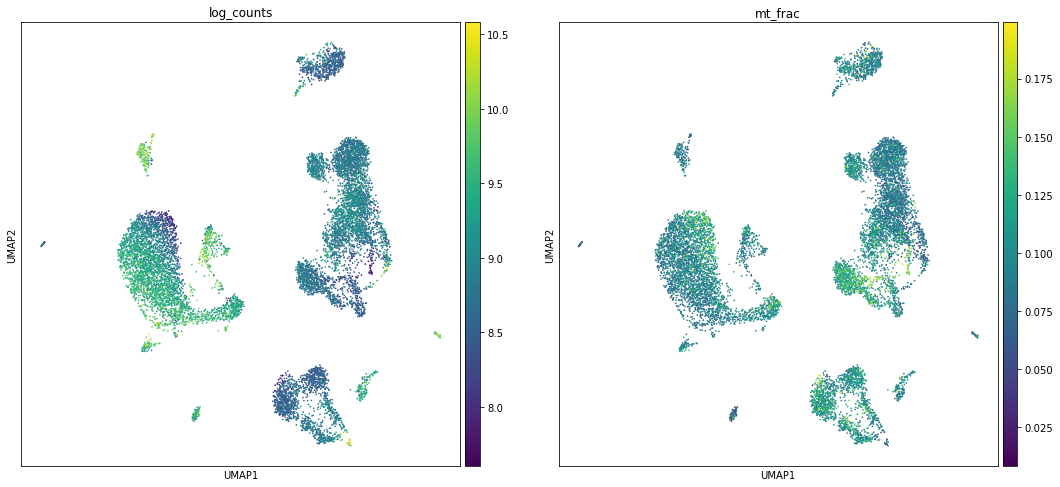

In [49]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



## Marker genes and cluster annotation (r 0.5)

In [50]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished (0:00:14)


In [51]:
# Known marker genes taken from PanglaoDB (short list of 12 cell types)
markers_short_df = pd.read_csv('../../Munich/Immune_markers_short_12.txt', delimiter='\t')
markers_short_df.shape

(975, 14)

In [52]:
markers_short_df.head()

,species,official.gene.symbol,cell.type,nicknames,ubiquitousness.index,product.description,gene.type,canonical.marker,germ.layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
417,Mm Hs,CD2,B cells,NaN,0.040,CD2 molecule,protein-coding gene,NaN,Mesoderm,Immune system,0.000000,0.212355,0.095847,0.026556
418,Mm Hs,CD5,B cells,NaN,0.004,CD5 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.000000,0.000000,0.004153,0.004502
419,Mm Hs,MS4A1,B cells,Bp35|MS4A2|CD20,0.014,membrane spanning 4-domains A1,protein-coding gene,1.0,Mesoderm,Immune system,0.483871,0.617761,0.011182,0.001566
420,Mm Hs,CR2,B cells,CD21|C3DR,0.001,complement C3d receptor 2,protein-coding gene,1.0,Mesoderm,Immune system,0.048387,0.034749,0.000000,0.000000
421,Mm Hs,CD22,B cells,SIGLEC-2|SIGLEC2,0.003,CD22 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.096774,0.127413,0.001278,0.000196


Select only genes that are annotated for human:

In [53]:
markers_short_df_hum = markers_short_df[(markers_short_df['species'] == 'Hs') | (markers_short_df['species'] == 'Mm Hs')]
markers_short_df_hum.shape

(892, 14)

In [54]:
cell_types = list(markers_short_df_hum['cell.type'].unique())

In [55]:
markers_dict = {}

In [56]:
for ctype in cell_types:
    df = markers_short_df_hum[markers_short_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [57]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5')
cell_annotation
    

,0,1,2,3,4,5,6,7,8,9,10,11,12
B cells,2.0,3.0,34.0,1.0,3.0,0.0,1.0,1.0,4.0,35.0,8.0,2.0,0.0
B cells naive,0.0,2.0,31.0,0.0,2.0,0.0,0.0,0.0,4.0,31.0,3.0,0.0,0.0
Dendritic cells,15.0,0.0,11.0,1.0,5.0,6.0,12.0,16.0,16.0,9.0,5.0,3.0,0.0
Erythroid-like and erythroid precursor cells,3.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0
Gamma delta T cells,0.0,0.0,0.0,0.0,12.0,18.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0
Monocytes,13.0,0.0,2.0,0.0,1.0,3.0,8.0,14.0,3.0,2.0,1.0,1.0,0.0
NK cells,1.0,5.0,0.0,1.0,22.0,29.0,3.0,2.0,2.0,1.0,1.0,0.0,2.0
Plasmacytoid dendritic cells,2.0,1.0,7.0,1.0,2.0,2.0,0.0,2.0,0.0,6.0,21.0,2.0,1.0
Platelets,4.0,1.0,2.0,0.0,3.0,6.0,2.0,4.0,1.0,3.0,4.0,2.0,30.0
T cells,1.0,15.0,2.0,7.0,27.0,17.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0


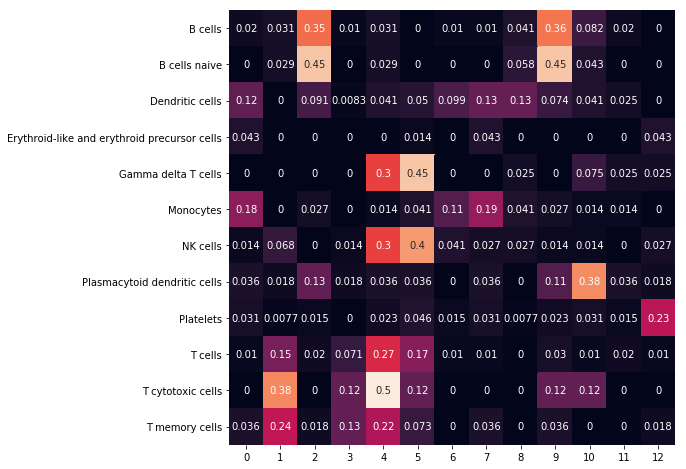

In [58]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [59]:
#Categories to rename
adata.obs['louvain_r0.5'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

In [62]:
adata.obs['cell_type0.5short'] = adata.obs['louvain_r0.5']
adata.obs['cell_type0.5short'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

In [80]:
adata.rename_categories('cell_type0.5short', ['Monocytes1', 'T cytotoxic1', 'B cells naive1', 'T memory', 'T cyctotoxic + NK', 'Gamma delta T cells + NK', 'Monocytes2', 'Monocytes3', 'Dendritic cells', 'B cells naive2', 'Plasmacytoid dendritic cells', 'Unknown', 'Platelets'])

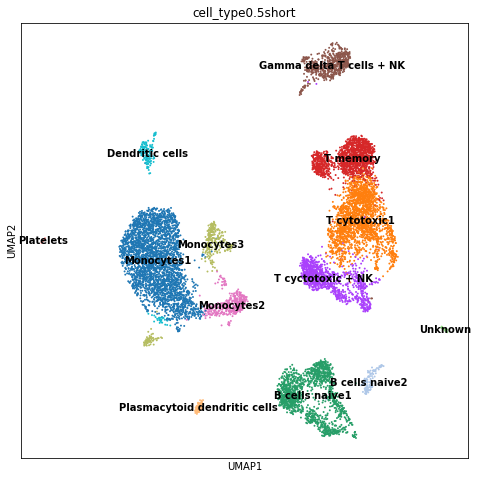

In [81]:
sc.pl.umap(adata, color='cell_type0.5short', size=15, legend_loc='on data')

### Long list of cell types
Here we try using the long list of cell types (29) from PanglaoDB, considering all cell types in "immune system" + "blood". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [72]:
markers_long_df = pd.read_csv('../../Munich/Immune_markers_long_29.txt', delimiter='\t')
markers_long_df.shape

(1866, 14)

In [73]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_long_df.shape

(1849, 14)

In [74]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Red pulp macrophages']
markers_long_df.shape

(1837, 14)

In [75]:
markers_long_df_hum = markers_long_df[(markers_long_df['species'] == 'Hs') | (markers_long_df['species'] == 'Mm Hs')]
markers_long_df_hum.shape

(1685, 14)

In [76]:
cell_types = list(markers_long_df_hum['cell.type'].unique())

In [77]:
markers_dict_long = {}
for ctype in cell_types:
    df = markers_long_df_hum[markers_long_df_hum['cell.type'] == ctype]
    markers_dict_long[ctype] = df['official.gene.symbol'].to_list()

In [78]:
cell_annotation_long = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5')

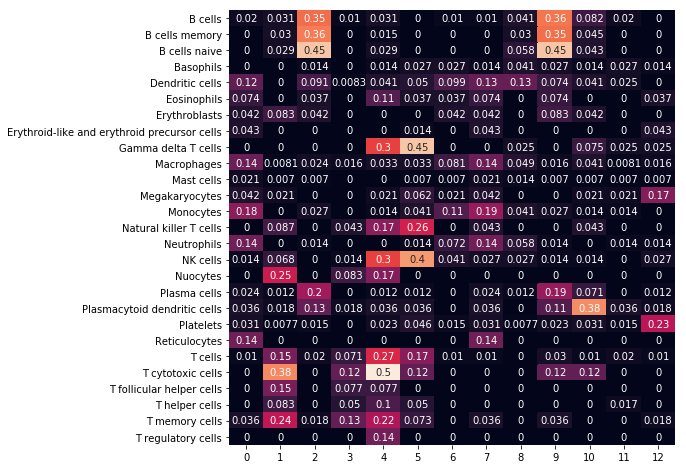

In [79]:
cell_annotation_long_norm = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_long_norm, cbar=False, annot=True)

In [82]:
# Categories to rename
adata.obs['cell_type0.5long'] = adata.obs['louvain_r0.5']
adata.rename_categories('cell_type0.5long', ['Monocytes1', 'T cytotoxic1', 'B cells naive1', 'T memory', 'T cyctotoxic + NK', 'Gamma delta T cells + NK', 'Monocytes2', 'Monocytes3', 'Dendritic cells', 'B cells naive2', 'Plasmacytoid dendritic cells', 'Unknown', 'Platelets'])

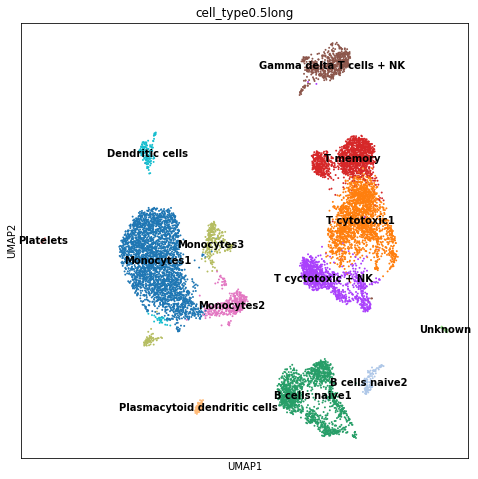

In [83]:
sc.pl.umap(adata, color='cell_type0.5long', size=15, legend_loc='on data')

Using the long list did NOT actually improve the annotation

## Markers and cluster annotation (r 1)

In [84]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')
cell_annotation_long_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1')

ranking genes
    finished (0:00:21)


### Short cell types list

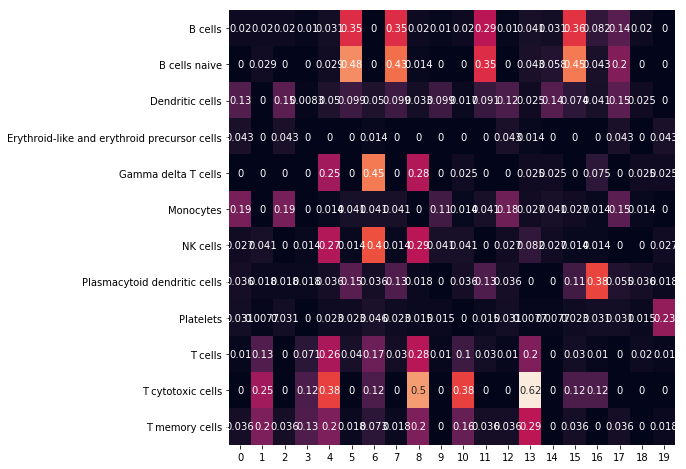

In [86]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [87]:
# Categories to rename
adata.obs['cell_type1short'] = adata.obs['louvain_r1']
adata.rename_categories('cell_type1short', ['Monocytes1', 'T cytotoxic1', 'Monocytes2', 'T memory1', 'T cytotoxic2', 'B cells naive1', 'Gamma delta T cells + NK', 'B cells naive2', 'T cytotoxic3', 'Monocytes3', 'T cytotoxic4', 'B cells naive3', 'Monocytes4', 'T cytotoxic5', 'Dendritic cells', 'B cells naive4',  'Plasmacytoid dendritic cells', 'B cells naive 5', 'Unknown', 'Platelets'])

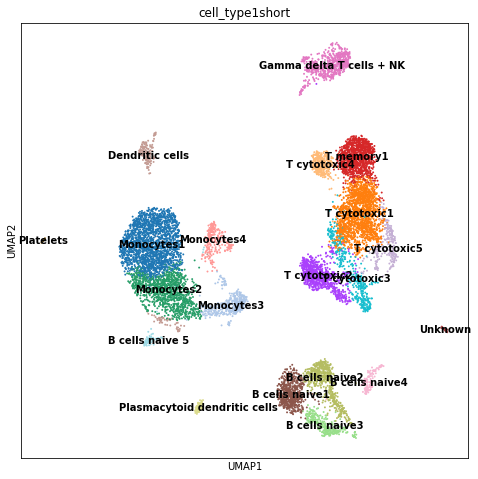

In [88]:
sc.pl.umap(adata, color='cell_type1short', size=15, legend_loc='on data')

### Long cell types list

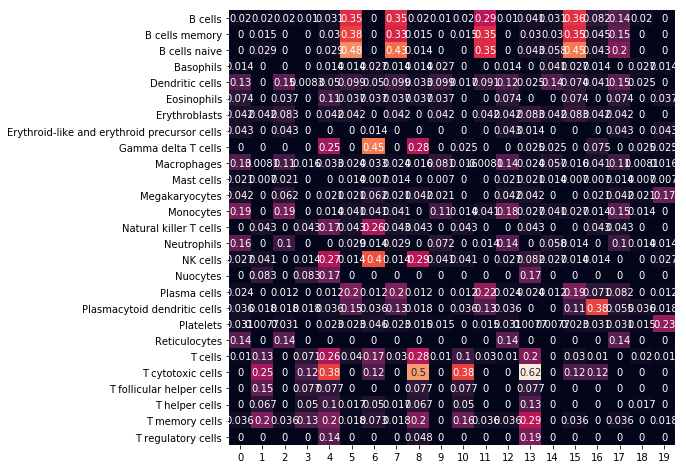

In [89]:
cell_annotation_long_norm_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_long_norm_r1, cbar=False, annot=True)

In [90]:
adata.write(results_file)